In [ ]:
# !pip install yfinance pmdarima prophet --quiet

import yfinance as yf

import pmdarima as pm

import warnings; warnings.filterwarnings('ignore')

origin = yf.download('GOOG', start='2022-10-25', end='2024-10-25')

In [2]:
import pandas, numpy as np

origin.iloc[:5]

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2022-10-25 00:00:00+00:00,104.672943,104.930000,105.099998,103.019997,103.300003,29910200
2022-10-26 00:00:00+00:00,94.587708,94.820000,98.540001,94.570000,96.760002,71504300
2022-10-27 00:00:00+00:00,92.373146,92.599998,95.169998,91.900002,94.309998,54036500
2022-10-28 00:00:00+00:00,96.343399,96.580002,96.860001,92.322998,92.529999,35696900
2022-10-31 00:00:00+00:00,94.428108,94.660004,96.349998,94.379997,95.779999,29868700


In [3]:
google = origin["Close"]

google.index = google.index.date

google.index.name = "Tanggal"

google.columns = ["Google Close"]

google.iloc[:5]

,Google Close
Tanggal,
2022-10-25,104.930000
2022-10-26,94.820000
2022-10-27,92.599998
2022-10-28,96.580002
2022-10-31,94.660004


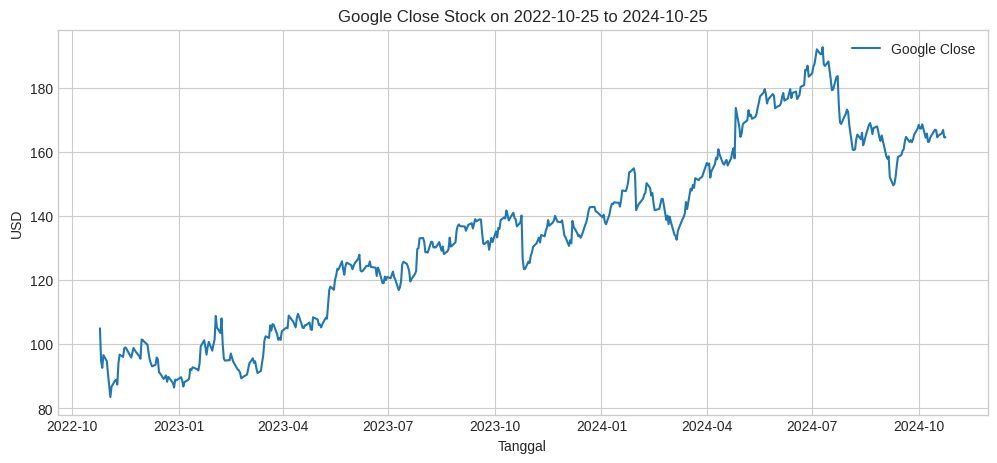

In [4]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

plt.rcParams["figure.figsize"] = (12, 5)

title = "Google Close Stock on 2022-10-25 to 2024-10-25"

google.plot.line(title=title, xlabel="Tanggal", ylabel="USD", rot=0);

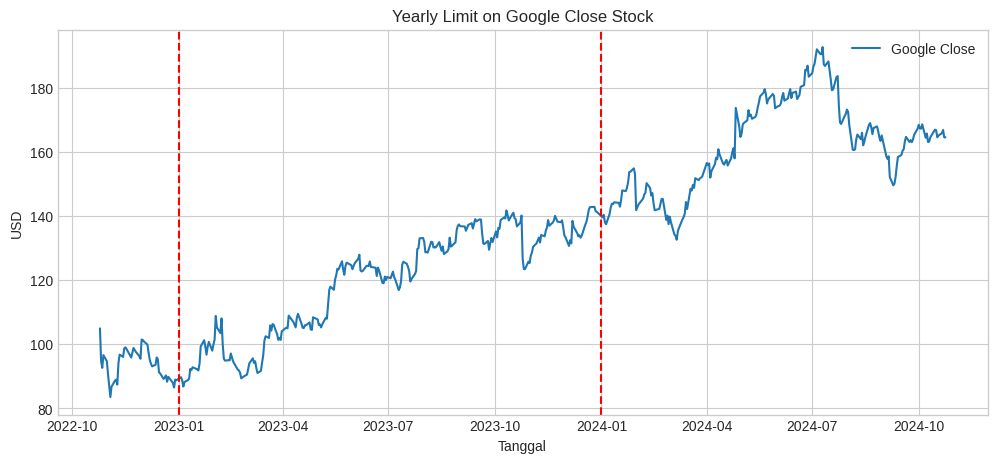

In [5]:
title = "Yearly Limit on Google Close Stock"

goplot = google.plot.line(title=title, xlabel="Tanggal", ylabel="USD")

for dately in ["2023-01-01", "2024-01-01"]:

  goplot.axvline(dately, color="r", linestyle="--");

In [6]:
google.isnull().sum().sum()

0

In [7]:
total_google = len(google)

total_google

503

In [8]:
google.index = pandas.to_datetime(google.index)

google.index.dtype

dtype('<M8[ns]')

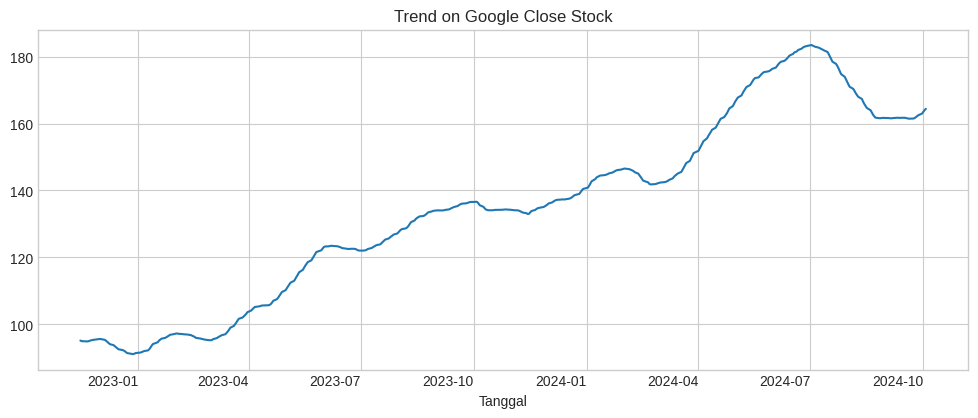

In [9]:
from statsmodels.tools.sm_exceptions import ValueWarning

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.simplefilter('ignore', ValueWarning)

seasonality = seasonal_decompose(google, period=30)

seasonality.trend.plot(title="Trend on Google Close Stock", rot=0);

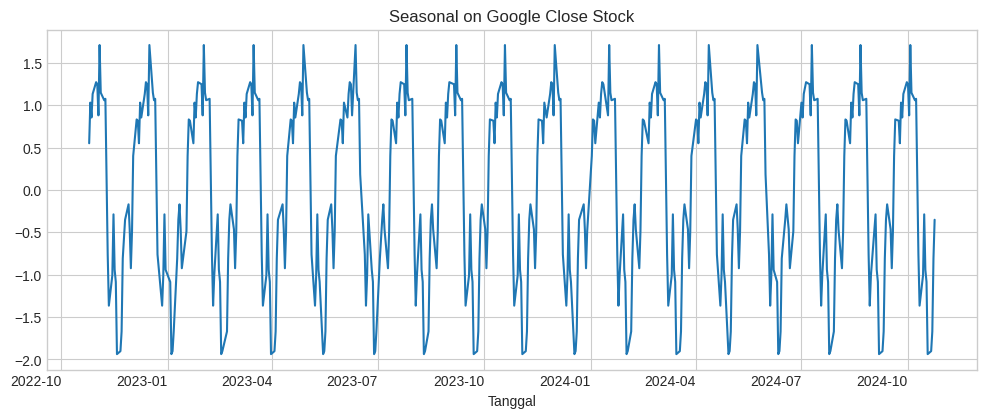

In [10]:
seasonality.seasonal.plot(title="Seasonal on Google Close Stock", rot=0);

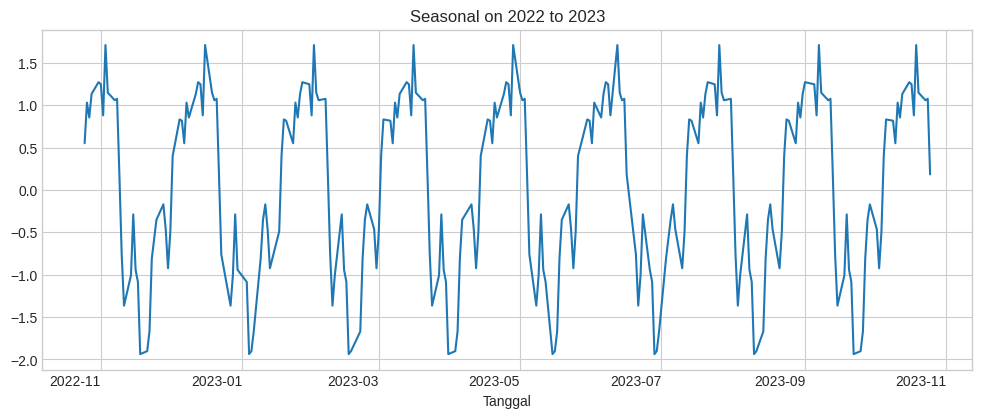

In [11]:
seaplot = seasonality.seasonal.loc["2022-10-25":"2023-10-25"]

seaplot.plot(title="Seasonal on 2022 to 2023", rot=0);

In [12]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(google)

test_statistic, p_value, used_lag, n_obs, critical_values, ic_best = adfuller_result

test_statistic, p_value

(-0.9821831362390908, 0.7597070011324065)

In [13]:
def test_stationary(adfuller_result, alpha=0.05):

  test_statistic, p_value, used_lag, n_obs, critical_values, ic_best = adfuller_result

  result_satu = p_value < alpha

  for value in critical_values.values():
    if test_statistic > value:
      last_result = False
      break
    last_result = True

  return result_satu, last_result

test_stationary(adfuller_result)

(False, False)

In [14]:
from pmdarima.arima import ADFTest

def time_series_should_diff(timeseries, alpha=0.05):

  should_diff = ADFTest(alpha=alpha)

  return should_diff.should_diff(timeseries)[1]

time_series_should_diff(google)

True

In [15]:
test_stationary(adfuller(google.diff().dropna()))

(True, True)

In [16]:
time_series_should_diff(google.diff().dropna())

False

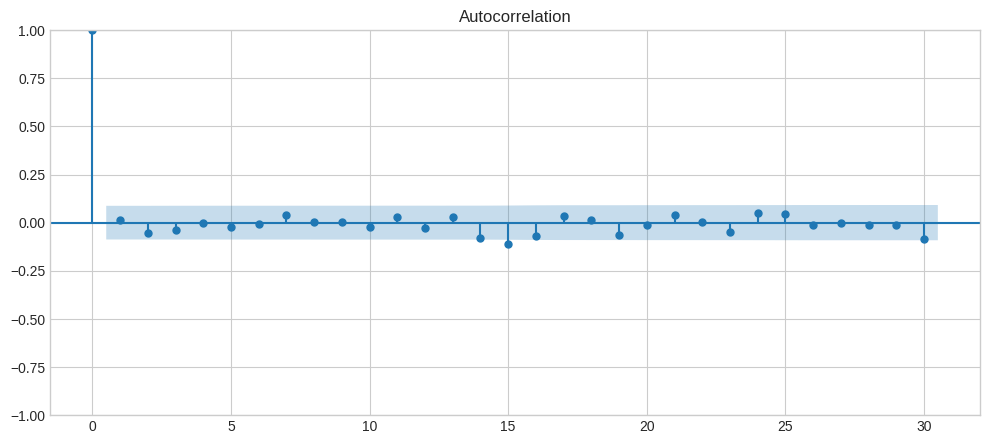

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(google.diff().dropna(), lags=30);

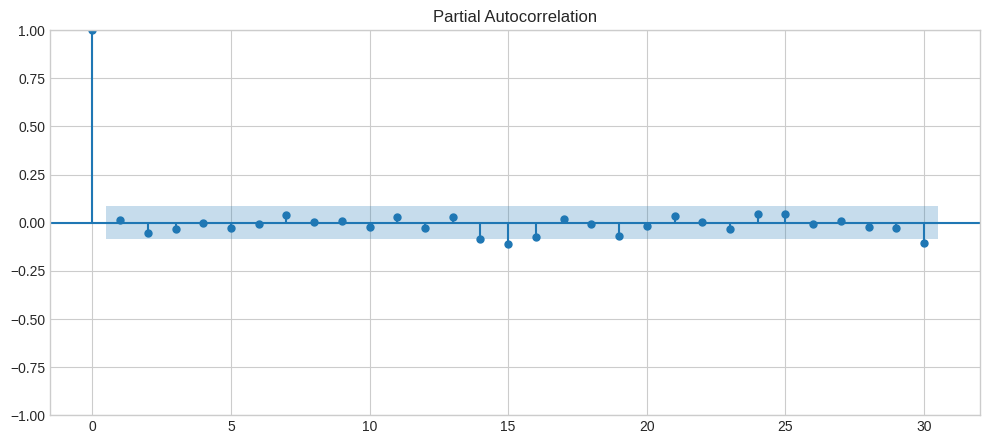

In [18]:
plot_pacf(google.diff().dropna(), lags=30);

In [19]:
train_split = google[:473]

test_split = google[473:]

train_split.shape, test_split.shape

((473, 1), (30, 1))

In [20]:
import numpy as np

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

orders = [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]

errors = []

for order in orders:

  model = ARIMA(train_split, order=order).fit()

  logits = model.forecast(len(test_split))

  errors.append(np.sqrt(mean_squared_error(test_split, logits)))

errors

[9.331523196875024, 9.268427215633347, 9.274133645911578, 8.837496397669014]

In [21]:
model = ARIMA(train_split, order=orders[np.argmin(errors)]).fit()

logits = model.forecast(len(test_split))

model.aic

2224.2931607341825

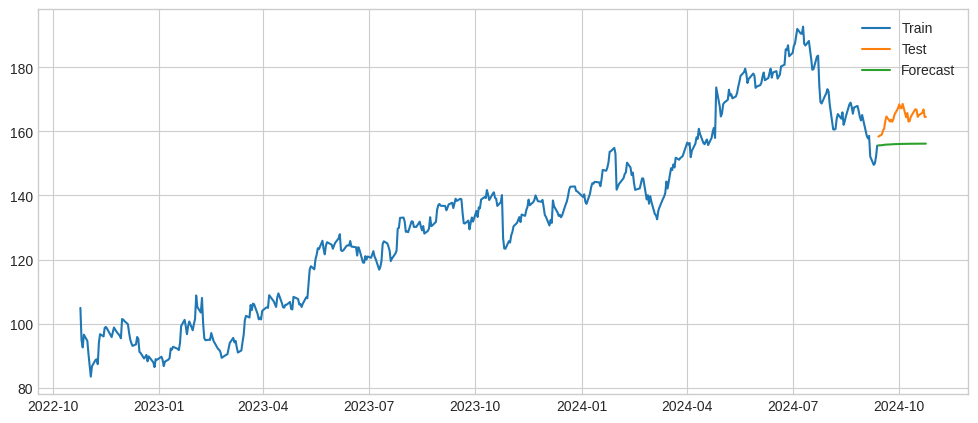

In [22]:
plt.plot(train_split.index, train_split, label="Train")

plt.plot(test_split.index, test_split, label="Test")

plt.plot(test_split.index, logits, label="Forecast")

plt.legend();

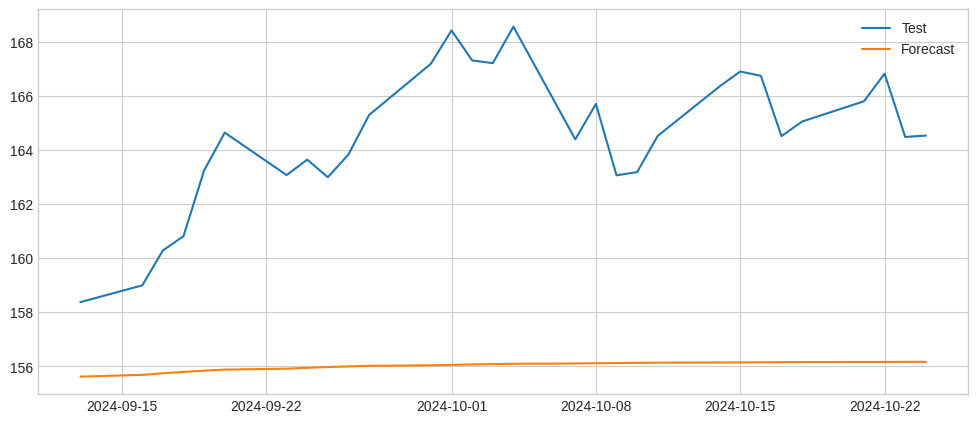

In [23]:
plt.plot(test_split.index, test_split, label="Test")

plt.plot(test_split.index, logits, label="Forecast")

plt.legend();

In [24]:
orders_seasonal = [(0, 1, 1, 15), (1, 1, 1, 15), (0, 1, 1, 30), (1, 1, 1, 30)]

error_list = []

order = orders[np.argmin(errors)]

for seasonal in orders_seasonal:

  seasonal = ARIMA(train_split, order=order, seasonal_order=seasonal).fit()

  logits = seasonal.forecast(len(test_split))

  errors = np.sqrt(mean_squared_error(test_split, logits))

  error_list.append(errors)

error_list

[8.067089655693142, 6.895123570113656, 6.174143866944952, 5.450443277685818]

In [25]:
seasonal = orders_seasonal[np.argmin(error_list)]

seasonal_model = ARIMA(train_split, order=order, seasonal_order=seasonal).fit()

logits = seasonal_model.forecast(len(test_split))

seasonal_model.aic

2180.9924864156274

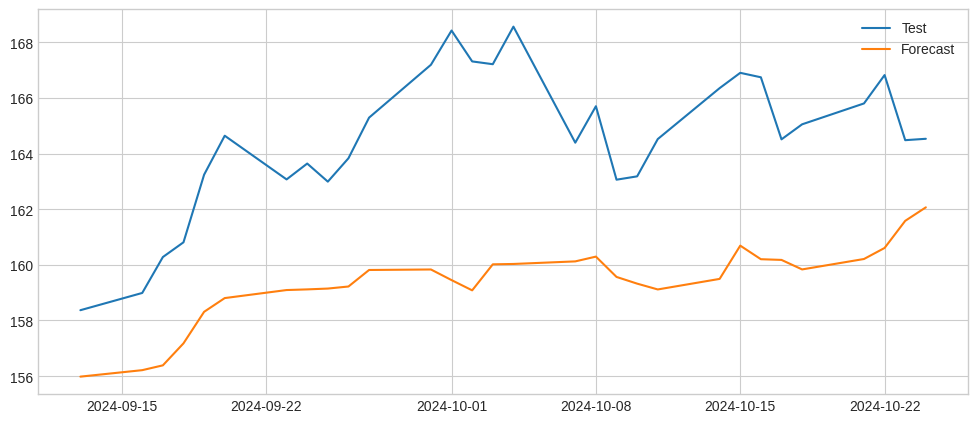

In [26]:
plt.plot(test_split.index, test_split, label="Test")

plt.plot(test_split.index, logits, label="Forecast")

plt.legend();